## Import Module

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input 
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


2024-07-21 05:12:45.994085: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 05:12:45.994185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 05:12:46.260387: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

## Extract Image Features

In [4]:
# load vgg16 model
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
vgg_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,479,232 (448.15 MB)

 Trainable params: 117,479,232 (448.15 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# load inceptionV3 model
iv_model = InceptionV3(weights = 'imagenet')
# restructure the model
iv_model = Model(iv_model.input, iv_model.layers[-2].output)
# summarize
iv_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 149, 149,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 147, 147,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 147, 147,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 73, 73,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 73, 73,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 71, 71,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [7]:
# save the model
vgg_model.save(WORKING_DIR+'/feature_model_vgg.keras')
# save the model
iv_model.save(WORKING_DIR+'/feature_model_inception.keras')

In [8]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir('/kaggle/input/flickr8k/Images')):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(299, 299))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = iv_model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1721539378.942785     155 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [10]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features_inception.pkl'), 'wb'))

In [11]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features_inception.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [12]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [13]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [14]:
len(mapping)

8091

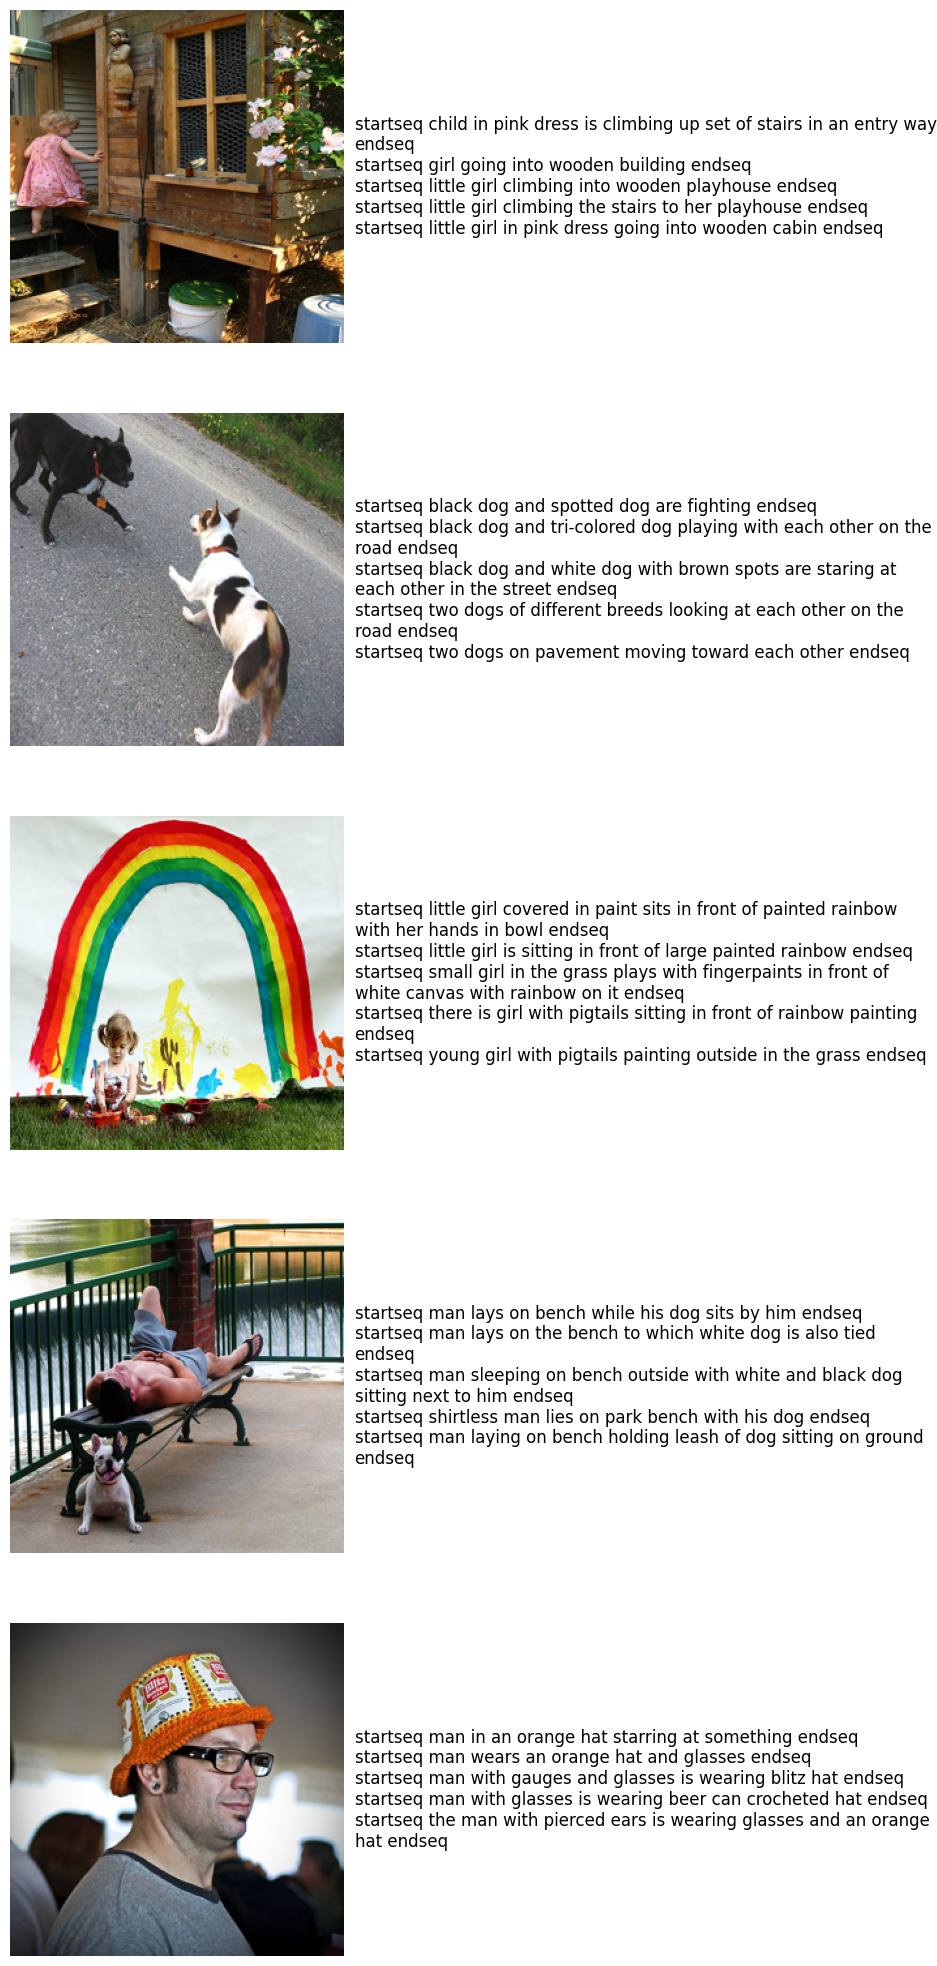

In [21]:
image_ids = sorted(mapping.keys())[:5]
# fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))
# # Set up the figure
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,20))
plt.subplots_adjust(wspace=0.5, hspace=1)

for idx, image_id in enumerate(image_ids):
        # Load the image
        img_path = os.path.join(directory, f"{image_id}.jpg")
        image = Image.open(img_path)
        
        # Resize the image to a fixed size (e.g., 256x256)
        image = image.resize((256,256))
        
        # Display the image
        axes[idx,0].imshow(image)
        axes[idx,0].axis('off')
        
        # Display the caption
        caption = "\n".join(mapping[image_id])
        axes[idx, 1].text(0, 0.5, caption, fontsize=12, wrap=True, verticalalignment='center')
        
        axes[idx,1].axis('off')
    
plt.tight_layout()
plt.show()

## Preprocess Text Data

In [15]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [16]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [17]:
# preprocess the text
clean(mapping)

In [18]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [19]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [20]:
len(all_captions)

40455

In [22]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [23]:
top_k=6000
# tokenize the text
tokenizer = Tokenizer(num_words=top_k,filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

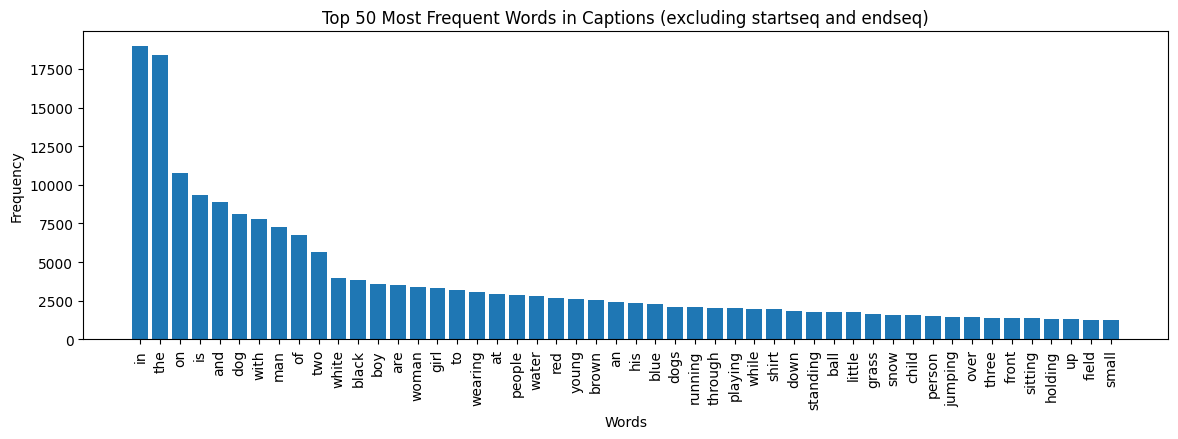

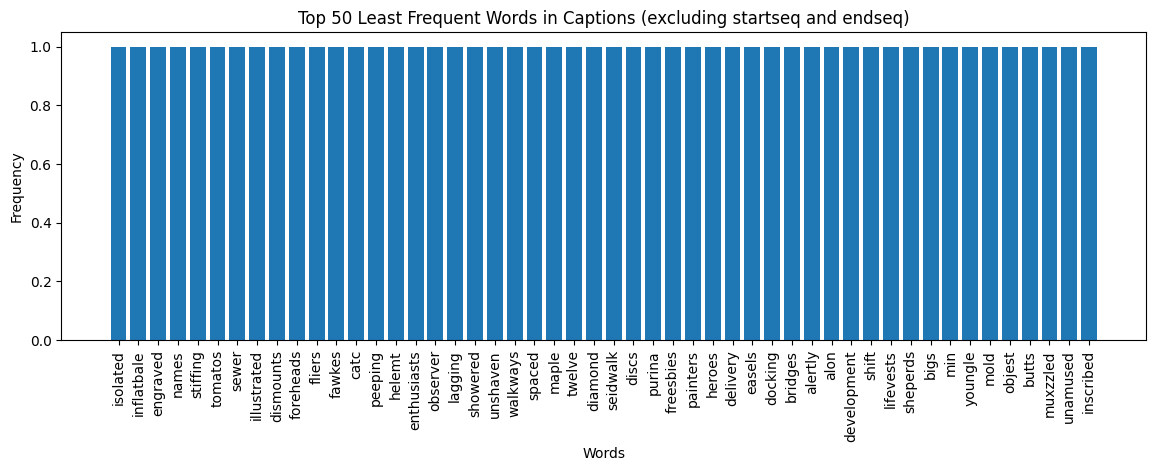

In [24]:
#most and least frequent words

# Get the word index
word_index = tokenizer.word_index

# Convert captions to sequences of word indices
sequences = tokenizer.texts_to_sequences(all_captions)

# Flatten the list of sequences to get a single list of word indices
all_words = [word for seq in sequences for word in seq]

# Calculate word frequencies
word_counts = Counter(all_words)

# Remove "startseq" and "endseq"
startseq_index = word_index.get('startseq')
endseq_index = word_index.get('endseq')
if startseq_index is not None:
    del word_counts[startseq_index]
if endseq_index is not None:
    del word_counts[endseq_index]

# Get the most common 50 words
most_common_50 = word_counts.most_common(50)

# Get the least common 50 words
least_common_50 = word_counts.most_common()[-50:]

# Map indices back to words
most_common_words = [(tokenizer.index_word[idx], count) for idx, count in most_common_50]

# Map indices back to words
least_common_words = [(tokenizer.index_word[idx], count) for idx, count in least_common_50]

# Prepare data for plotting
words_least, counts_least = zip(*least_common_words)

# Prepare data for plotting
words_most, counts_most = zip(*most_common_words)

# Plotting
plt.figure(figsize=(14, 4))
plt.bar(words_most, counts_most)
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 Most Frequent Words in Captions (excluding startseq and endseq)')
plt.show()

# Plotting
plt.figure(figsize=(14, 4))
plt.bar(words_least, counts_least)
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 Least Frequent Words in Captions (excluding startseq and endseq)')
plt.show()

In [25]:
vocab_size

8485

In [26]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [28]:
from sklearn.model_selection import train_test_split

# Split data into train and temp (for validation and test)
image_ids = list(mapping.keys())
train_ids, temp_ids = train_test_split(image_ids, test_size=0.20, random_state=42)

# Split temp into validation and test
val_ids, test_ids = train_test_split(temp_ids, test_size=0.50, random_state=42)

print(f"Number of training samples: {len(train_ids)}")
print(f"Number of validation samples: {len(val_ids)}")
print(f"Number of testing samples: {len(test_ids)}")


Number of training samples: 6472
Number of validation samples: 809
Number of testing samples: 810


In [29]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [30]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

## Model Creation

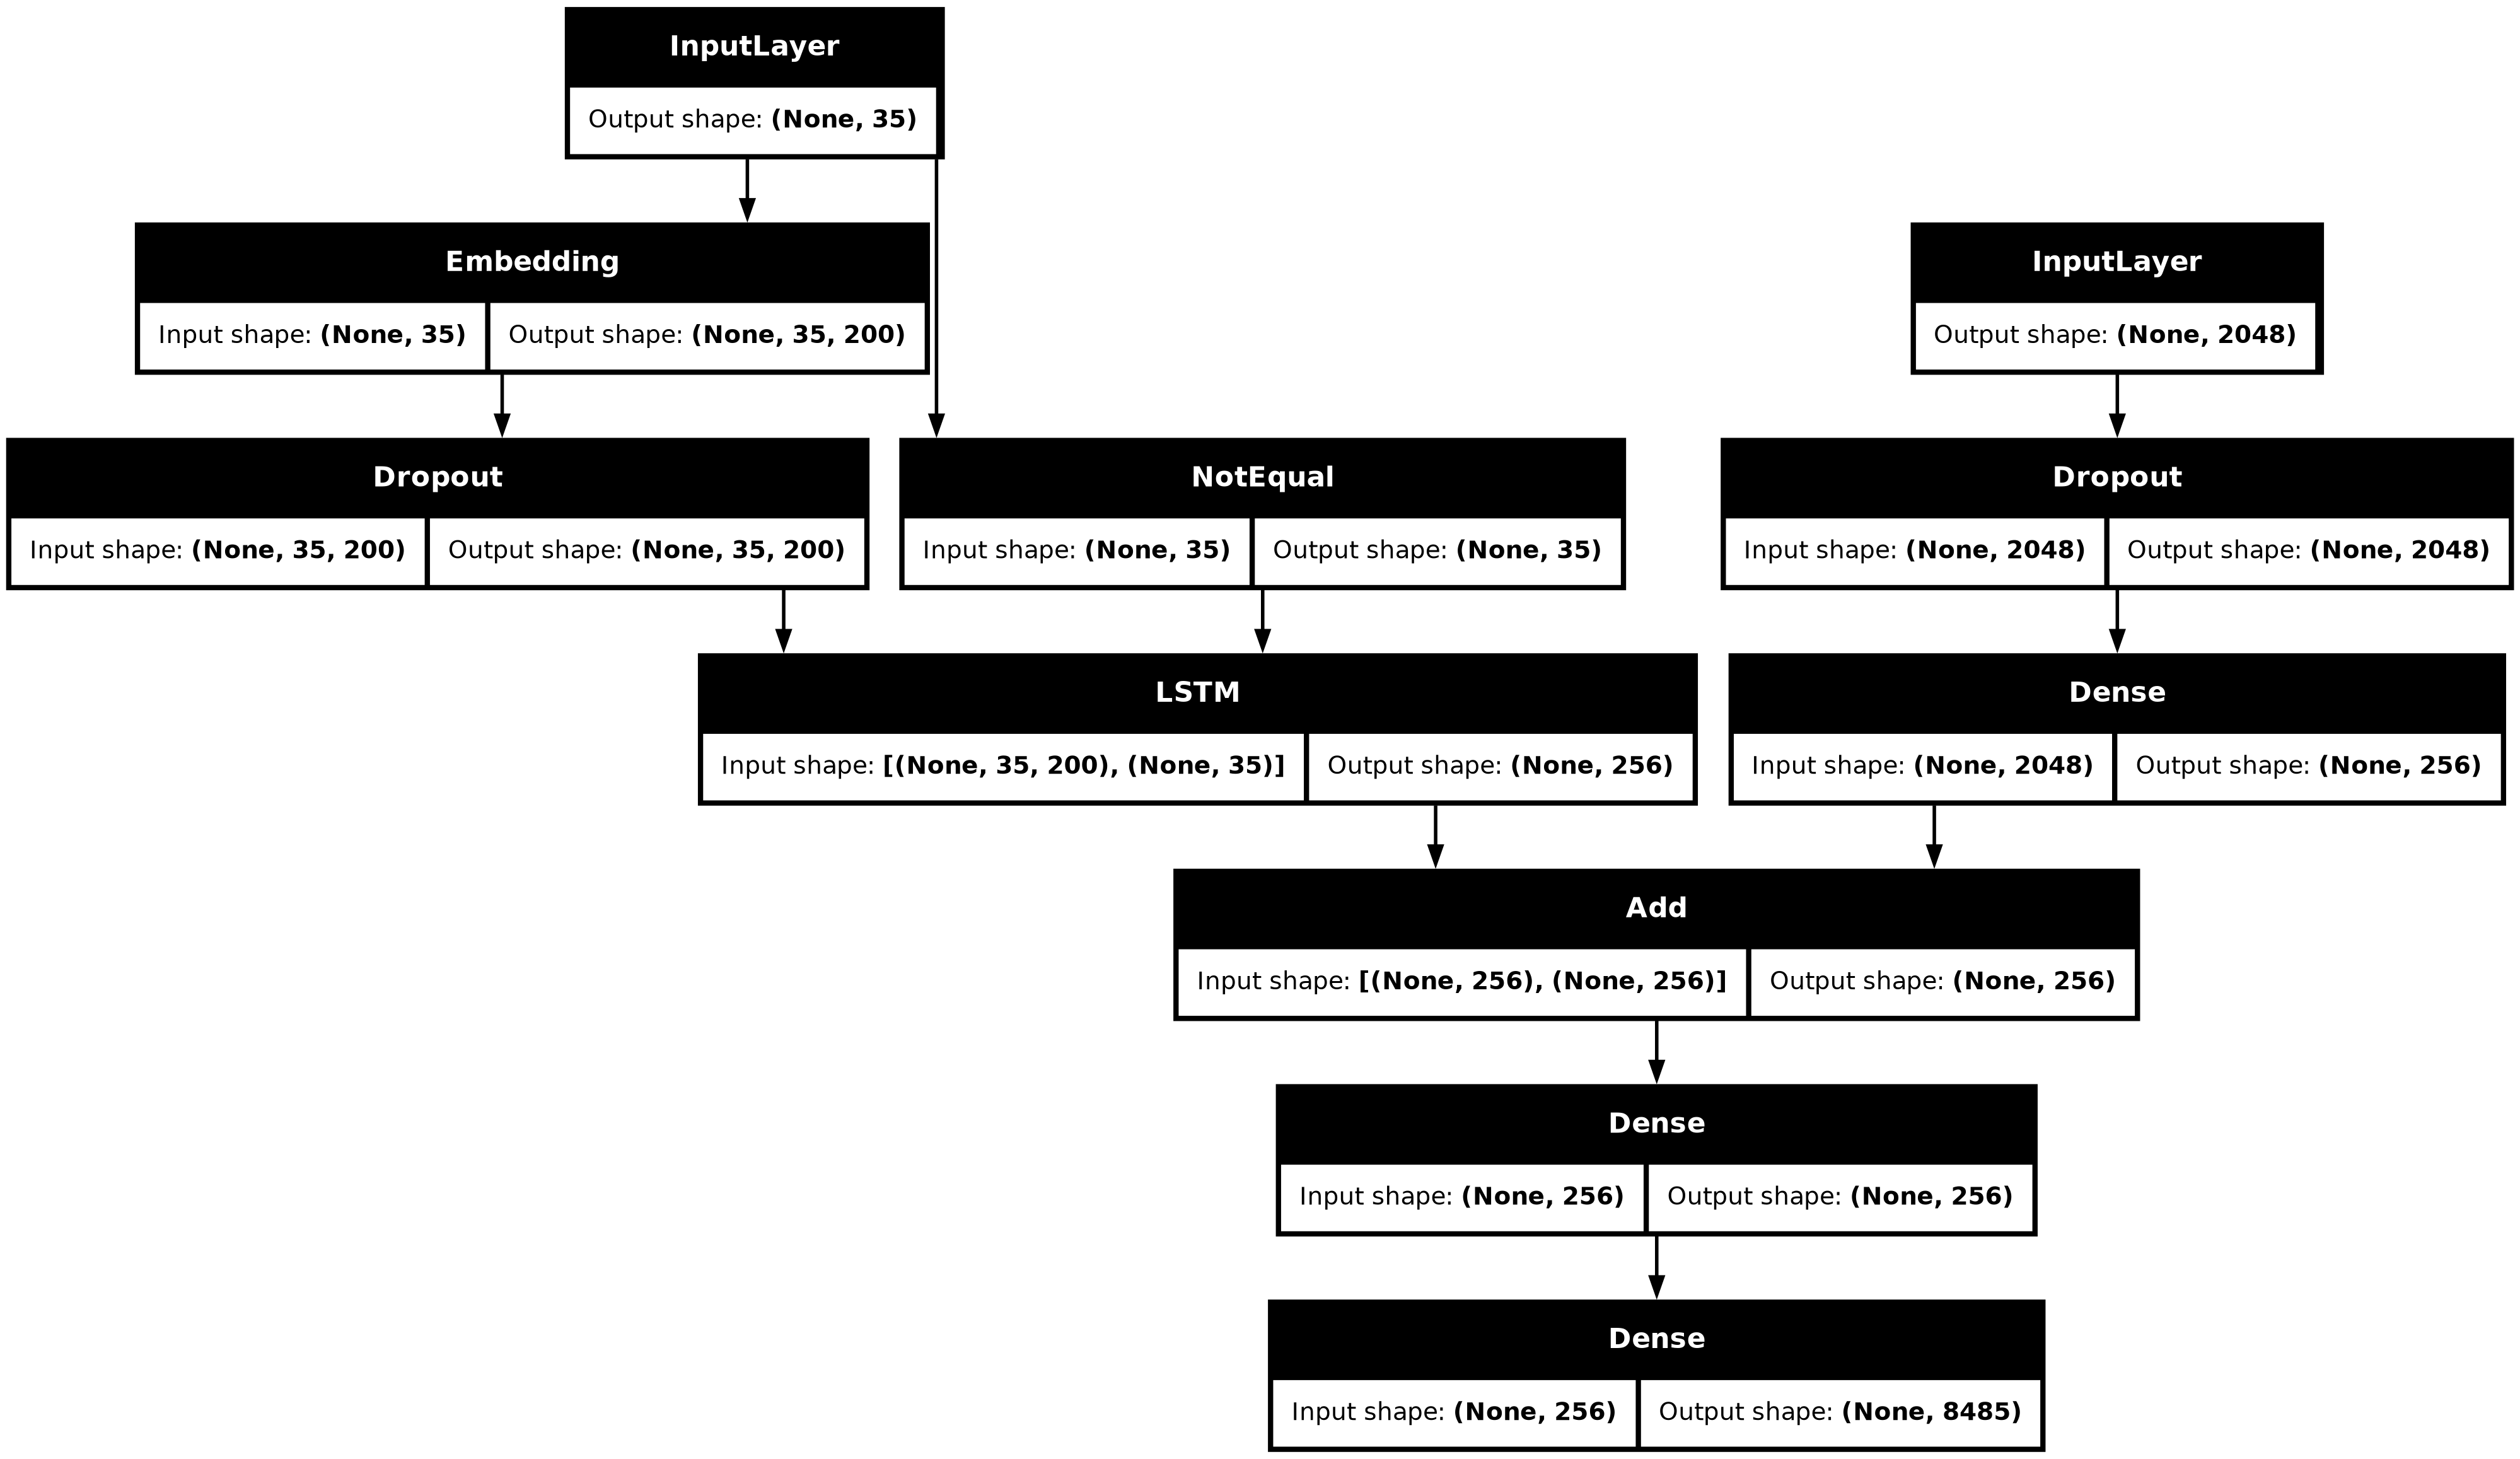

In [31]:
# encoder model
# image feature layers
inputs1 = Input(shape=(2048,), name="image")
fe1 = Dropout(0.2)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 200, mask_zero=True)(inputs2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256, recurrent_activation='sigmoid', use_bias=True)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [32]:
# Train the model
epochs = 15
batch_size = 64

# Create data generators
train_generator = data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)
val_generator = data_generator(val_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)

steps_per_epoch = len(train_ids) // batch_size
validation_steps = len(val_ids) // batch_size

# Fit the model
hist = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    verbose=2
)

Epoch 1/15
101/101 - 60s - 594ms/step - loss: 5.7751 - val_loss: 5.0063
Epoch 2/15
101/101 - 54s - 538ms/step - loss: 4.4487 - val_loss: 4.1066
Epoch 3/15
101/101 - 56s - 554ms/step - loss: 3.8441 - val_loss: 3.8692
Epoch 4/15
101/101 - 53s - 524ms/step - loss: 3.5564 - val_loss: 3.7433
Epoch 5/15
101/101 - 56s - 558ms/step - loss: 3.3686 - val_loss: 3.7011
Epoch 6/15
101/101 - 54s - 539ms/step - loss: 3.2252 - val_loss: 3.6890
Epoch 7/15
101/101 - 55s - 544ms/step - loss: 3.1116 - val_loss: 3.6536
Epoch 8/15
101/101 - 55s - 540ms/step - loss: 3.0174 - val_loss: 3.6310
Epoch 9/15
101/101 - 55s - 543ms/step - loss: 2.9317 - val_loss: 3.6316
Epoch 10/15
101/101 - 55s - 544ms/step - loss: 2.8571 - val_loss: 3.6572
Epoch 11/15
101/101 - 55s - 543ms/step - loss: 2.7886 - val_loss: 3.6371
Epoch 12/15
101/101 - 54s - 536ms/step - loss: 2.7282 - val_loss: 3.6552
Epoch 13/15
101/101 - 54s - 536ms/step - loss: 2.6681 - val_loss: 3.6908
Epoch 14/15
101/101 - 54s - 537ms/step - loss: 2.6154 - val_

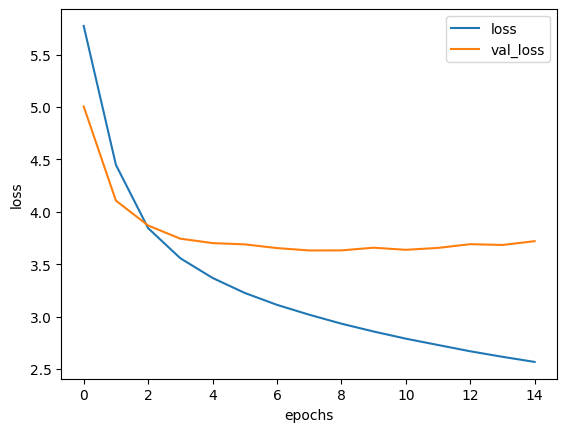

In [33]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [34]:
# save the model
model.save(WORKING_DIR+'/image_caption_best_model.keras')

## Generate Captions for the Image

In [35]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [36]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [37]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
# from rouge_score import rouge_scorer
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.598841
BLEU-2: 0.378338
BLEU-3: 0.251431
BLEU-4: 0.158733


## Visualize the Results

In [52]:
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    actual_captions = [caption.split() for caption in captions]  # Split the actual captions into words
    y_pred = y_pred.split()  # Split the predicted caption into words
    
    smoothing_function = SmoothingFunction().method4
    
    bleu1 = corpus_bleu([actual_captions], [y_pred], weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
    bleu2 = corpus_bleu([actual_captions], [y_pred], weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
    bleu3 = corpus_bleu([actual_captions], [y_pred], weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing_function)
    bleu4 = corpus_bleu([actual_captions], [y_pred], weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)
    
    print(f'BLEU-1: {bleu1}')
    print(f'BLEU-2: {bleu2}')
    print(f'BLEU-3: {bleu3}')
    print(f'BLEU-4: {bleu4}')

---------------------Actual---------------------
startseq two different breeds of brown and white dogs play on the beach endseq
startseq two dogs are making turn on soft sand beach endseq
startseq two dogs playing in the sand at the beach endseq
startseq two dogs playing together on beach endseq
startseq two large tan dogs play along sandy beach endseq
--------------------Predicted--------------------
startseq two dogs are playing in the snow endseq
BLEU-1: 0.8888888888888888
BLEU-2: 0.7453559924999299
BLEU-3: 0.6227700724866008
BLEU-4: 0.4463236137853328


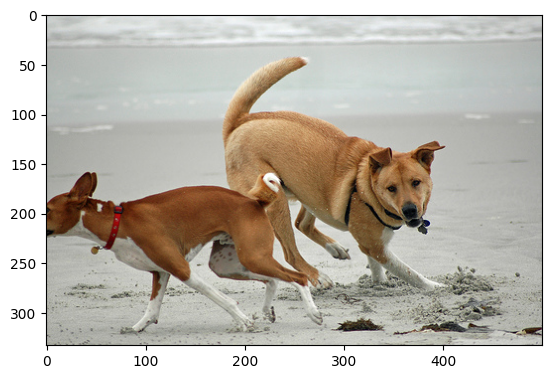

In [53]:
generate_caption("1024138940_f1fefbdce1.jpg")

---------------------Actual---------------------
startseq lone skier is making their way up mountain endseq
startseq skiiers at the top of snow covered hill endseq
startseq two hikers climbing snowy hill endseq
startseq two people are on snow-covered mountain endseq
startseq two people climbing up snowy mountain endseq
--------------------Predicted--------------------
startseq person on snowy peak endseq
BLEU-1: 0.5643211499270759
BLEU-2: 0.35499371368163696
BLEU-3: 0.28445157866334914
BLEU-4: 0.23885959762014747


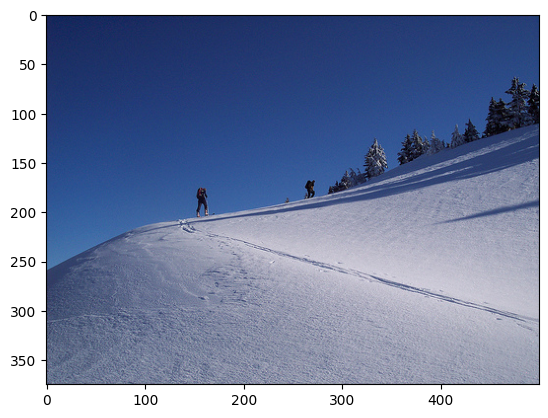

In [54]:
generate_caption("108899015_bf36131a57.jpg")